In [1]:
import numpy as np
from matplotlib import pyplot as plt
import h5py
import glob
import json
import import_ipynb
#Import .ipynb file that reads the .hdf5 files
import read_ligo

importing Jupyter notebook from read_ligo.ipynb


This assignment focuses on finding gravitational waves. This file will be the main, where I will use functions from other jupyter notebooks to keep everything organized. Let's get started by loading all of the data files.

In [2]:
#Define file path location
filepath = 'LOSC_Event_tutorial/LOSC_Event_tutorial/'

#I will denote Hanford data with '_H' and Livingston data with '_L'
#Create an array of the files of interest
files_H  = ['H-H1_LOSC_4_V2-1126259446-32.hdf5','H-H1_LOSC_4_V2-1128678884-32.hdf5',
            'H-H1_LOSC_4_V2-1135136334-32.hdf5','H-H1_LOSC_4_V1-1167559920-32.hdf5'] 
files_L  = ['L-L1_LOSC_4_V2-1126259446-32.hdf5','L-L1_LOSC_4_V2-1128678884-32.hdf5',
            'L-L1_LOSC_4_V2-1135136334-32.hdf5','L-L1_LOSC_4_V1-1167559920-32.hdf5'] 

#Initialize the strains
strains_H, strains_L = np.zeros([len(files_H), 131072]), np.zeros([len(files_L), 131072])

#Initialize utc
utc_H, utc_L = [], []

#Create array with all the filters files and the filters at Hanford and Livingston
templates = np.array(['GW150914_4_template.hdf5','LVT151012_4_template.hdf5',
                      'GW151226_4_template.hdf5','GW170104_4_template.hdf5'])
t_H, t_L = np.zeros([len(templates), 131072]), np.zeros([len(templates), 131072])

#Loop over the files_H and files_L to save all of the strains utcs, dts, filters, and templates
for i in range(len(files_H)):
    print('Reading files:', files_H[i], 'and', files_L[i])
    strains_H[i,:], dt, utc_1 = read_ligo.read_file(filepath+files_H[i])
    strains_L[i,:], dt, utc_2 = read_ligo.read_file(filepath+files_L[i])
    utc_H.append(utc_1)
    utc_L.append(utc_2)
    t_H[i:,],t_L[i:,] = read_ligo.read_template(filepath+templates[i])
    
#Turn utcs into arrays for later
np.array(utc_H)
np.array(utc_L)

#Define event names
events = ['GW150914','LVT151012','GW151226','GW170104']

Reading files: H-H1_LOSC_4_V2-1126259446-32.hdf5 and L-L1_LOSC_4_V2-1126259446-32.hdf5


<string>:21: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
<string>:23: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
<string>:24: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
<string>:25: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


Reading files: H-H1_LOSC_4_V2-1128678884-32.hdf5 and L-L1_LOSC_4_V2-1128678884-32.hdf5
Reading files: H-H1_LOSC_4_V2-1135136334-32.hdf5 and L-L1_LOSC_4_V2-1135136334-32.hdf5
Reading files: H-H1_LOSC_4_V1-1167559920-32.hdf5 and L-L1_LOSC_4_V1-1167559920-32.hdf5


### Question 1 a)

In [3]:
import noise
import waves
import snr

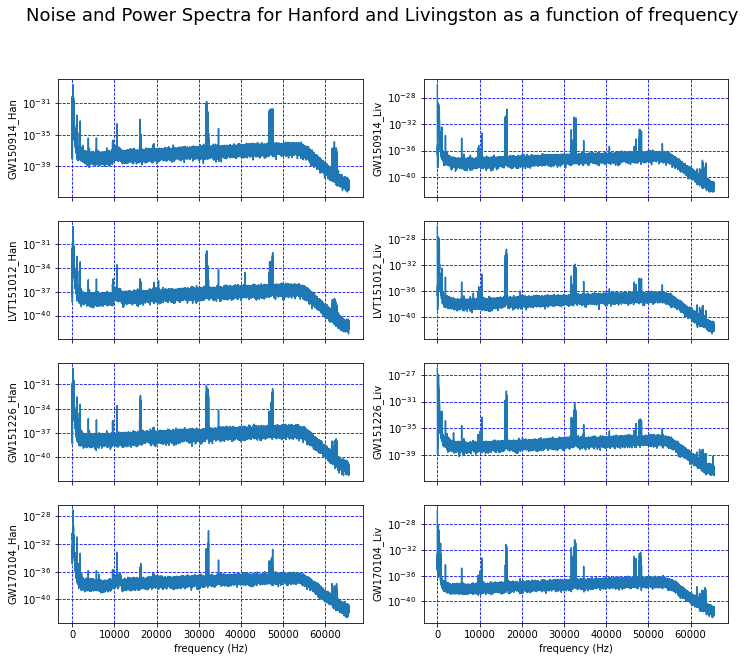

In [4]:
#Define a window to account for boundaries
#Define a cosine window like in lecture
x = np.arange(len(strains_H[0]))
x = x - 1.0*x.mean()
window = 0.5*(1 + np.cos(x*np.pi/np.max(x)))

#Plot the noise models for each event
fig, ax = plt.subplots(4, 2, sharex = True, figsize = (12,10))
fig.suptitle('Noise and Power Spectra for Hanford and Livingston as a function of frequency', size='18')

for i in range(len(events)):
    #From plot_noise() in waves.py
    #Gaussian smoothing the power spectrum from noise.noise_model()
    waves.plot_noise(events[i], strains_H[i], strains_L[i], t_H[i], t_L[i], window, i, fig, ax)
    ax[i,0].grid(b=True, color='b', linestyle='--')
    ax[i,1].grid(b=True, color='b', linestyle='--')
    
#Save the figure and show below as well; H on the left and L on the right side column
plt.savefig('noise_models.png')
plt.show()
plt.close()

When coming up with a noise model for the Livingston and Hanford, we assume a stationary Gaussian model, where the noise is not represented as a function of time. This idea is justified because the noise should not depend on time.

To accomplish this, we follow the same method as in lectures where we pass in a window (cosine) to the strains, and then apply a Gaussian filter for smoothing. A cosine window is chosen in order to ensure that the edges have a value of 0 to simplify the fourier transform. Before applying the filter, the power spectrum has to be in real fourier space. The power spectrum is convolved with the Gaussian filter.

### Question 1 b)

Using this noise model we defined, we can search the sets of events using a matched filter. The mapping between data and templates can be found in the file BBH_events_v3.json. The functions that will be necessary to use are found in noise.py and waves.py. First, we need to generate the time data.

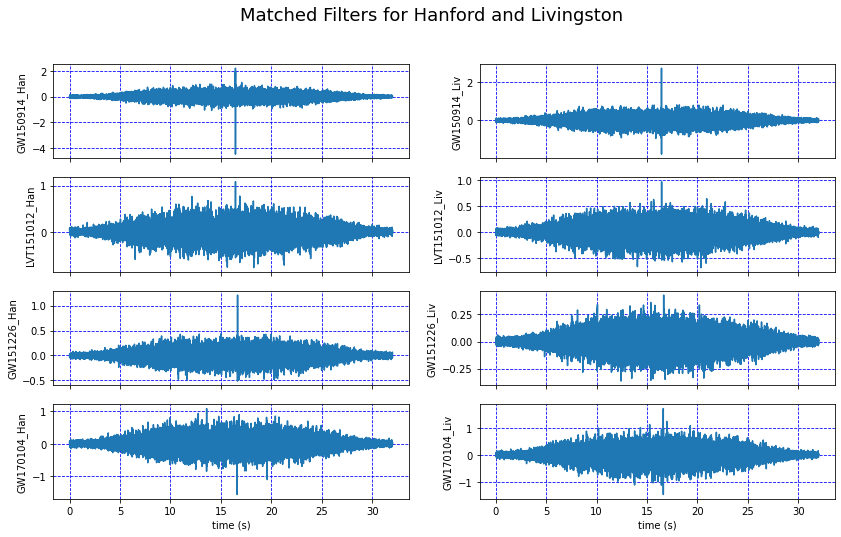

In [5]:
Time = np.linspace(0,len(strains_H[0])/4096,len(strains_H[0]))
fig, ax = plt.subplots(4, 2, sharex = True, figsize = (14,8))
fig.suptitle('Matched Filters for Hanford and Livingston', size='18')

#Iterate over the events to compute the matched filters
for i in range(len(events)):
    #Need to use waves.py
    waves.plot_mf(events[i], strains_H[i], strains_L[i], t_H[i], t_L[i], window, Time, i, fig, ax)
    ax[i,0].grid(b=True, color='b', linestyle='--')
    ax[i,1].grid(b=True, color='b', linestyle='--')
    
plt.savefig('matched_filters_plot.png')
plt.show()
plt.close()

We apply a matched filter, performed from the module waves.py, that takes in the whitened data and the templates. The plots are also saved in matched_filters_plot.png. First, we get the power spectrum for L and H from noise.py, and then we whiten the data with the whitening() in noise.py. The matched filters are then computed.

### Question 1 c)

Next, we will estimate the noise and give a signal to noise ratio for each event from the individual detectors and from the combined Livingston+Hanford events.

The signal to noise ratio is given by $m*\sqrt{({(A*N^{\frac{1}{2}})}^T*{(A*N^{\frac{1}{2}})})}$.

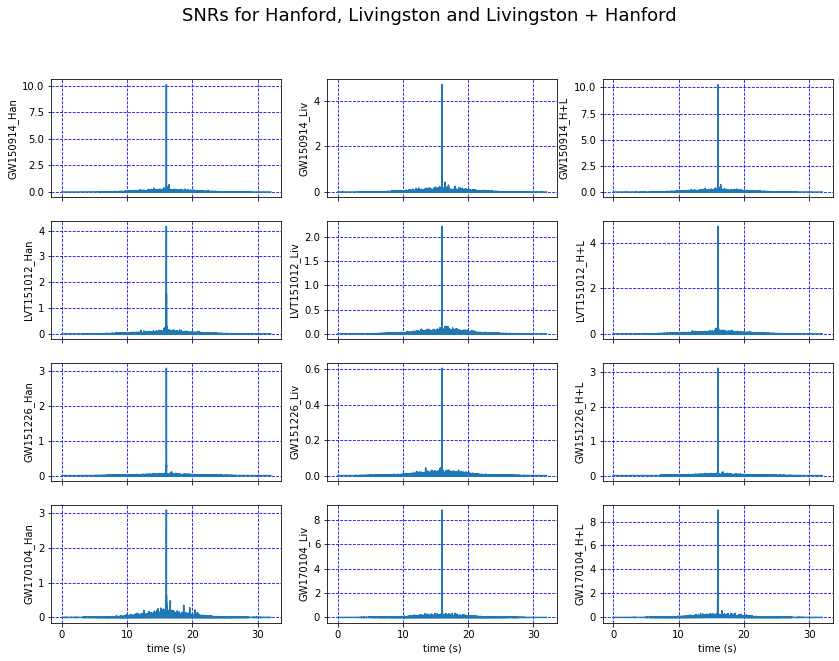

In [6]:
fig, ax = plt.subplots(4, 3, sharex = True, figsize = (14,10))
fig.suptitle('SNRs for Hanford, Livingston and Livingston + Hanford', size='18')

#Iterate through the events to compute the SNRs
for i in range(len(events)):
    #Using plot_SNR found in snr.py
    snr.plot_SNR(events[i], strains_H[i], strains_L[i], t_H[i], t_L[i], window, Time, i, fig, ax)
    ax[i,0].grid(b=True, color='b', linestyle='--')
    ax[i,1].grid(b=True, color='b', linestyle='--')
    ax[i,2].grid(b=True, color='b', linestyle='--')
    
#Save the plots in "signal_to_noise_ratio_plots.png" for later
plt.savefig('signal_to_noise_ratio_plots.png')
plt.show()
plt.close()

### Question 1 d)

Compare the signal to noise you get from the scatter in the matched filter to the analytic signal to noise you expect from your noise model. How close are they? If they disagree, can you explain why?

First, we must compute the theoretical signal to noise ratios derived from the noise model that we made, and then compare these to the result of the computed signal to noise ratios.

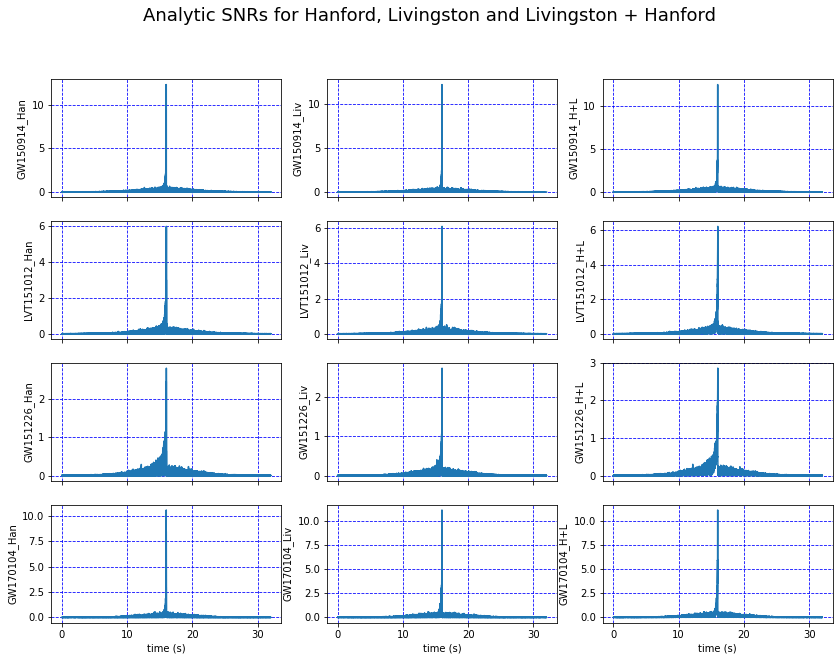

In [7]:
fig, ax = plt.subplots(4, 3, sharex = True, figsize = (14,10))
fig.suptitle('Analytic SNRs for Hanford, Livingston and Livingston + Hanford', size = '18')

for i in range(len(events)):
    #Using plot_theory_SNR in snr.py
    #Get the analytical solution of the signal to noise ratio for each detector and both combined
    snr.plot_theory_SNR(events[i], strains_H[i], strains_L[i], t_H[i], t_L[i], window, Time, i, fig, ax)
    ax[i,0].grid(b=True, color='b', linestyle='--')
    ax[i,1].grid(b=True, color='b', linestyle='--')
    ax[i,2].grid(b=True, color='b', linestyle='--')
    
#Save the figure
plt.savefig('analytic_signal_to_noise_ratio_plots.png')
plt.show()
plt.close()

The analytical model is computed by getting the signal to noise ratio from the noise model. We observe that the peaks occur at the same times, and that the y data tends to be greater than the previously calculated signal to noise ratios. Perhaps the differences in the peak amplitudes are due to an incorrect noise model, and that noise is not always stationary throughout the dataset.

We also see that the shape of the distributions is slightly different. This is also probably due to the fact that the noise is not entirely stationary.

### Question 1 e)

From the template and noise model, find the frequency from each event where half the weight comes from above that frequency and half below.

In [8]:
#Get the frequency; transforming x in fourier space
s = len(strains_H[0])
frequency = np.fft.rfftfreq(s, dt)

#Function that computes the middle weighted frequency
def middle_frequency(event, strain_H, strain_L, t_H, t_L, window, frequency):
    #Get the noise for H and L
    pow_H = noise.noise_model(strain_H, window)
    pow_L = noise.noise_model(strain_L, window)
    
    #Get the whitened strains
    A_white_H = noise.whitening(t_H, pow_H, window)
    A_white_L = noise.whitening(t_L, pow_L, window)

    #Add the power spectra
    sum_H = np.cumsum(np.abs(A_white_H**2))
    sum_L = np.cumsum(np.abs(A_white_L**2))

    #Compute and return the middle weighted frequency
    mid_freq_H = frequency[np.argmin(np.abs(sum_H - (np.amax(sum_H)/2)))]
    mid_freq_L = frequency[np.argmin(np.abs(sum_L - (np.amax(sum_L)/2)))]

    return mid_freq_H, mid_freq_L

#Get the middle frequency for each event
for i in range(len(events)):
    print('Event name: '+ events[i] +'\n')
    #Using middle_frequency() from waves.py
    mid_H, mid_L = middle_frequency(events[i], strains_H[i], strains_L[i], t_H[i], t_L[i], window, frequency)
    m_H = str(mid_H)
    m_L = str(mid_L)
    print('The middle frequency for Hanford is '+ m_H +'Hz\n')
    print('The middle frequency for Livingston is '+ m_L +'Hz\n\n')

Event name: GW150914

The middle frequency for Hanford is 100.25Hz

The middle frequency for Livingston is 115.34375Hz


Event name: LVT151012

The middle frequency for Hanford is 75.8125Hz

The middle frequency for Livingston is 94.21875Hz


Event name: GW151226

The middle frequency for Hanford is 74.15625Hz

The middle frequency for Livingston is 107.0625Hz


Event name: GW170104

The middle frequency for Hanford is 93.71875Hz

The middle frequency for Livingston is 76.25Hz




### Question 1 f)

How well can you localize the time of arrival (the horizontal shift of your matched filter)? The positions of gravitational wave events are inferred by comparing their arrival times at different detectors. What is the typical positional uncertainy you might expect given that the detectors area a few thousand km apart?

A possible solution to this could be to fit the peaks with a Gaussian. The fit parameters that we return will reveal information about the time of arrival (from the mean of the Gaussian), and the error (from the standard deviation).

In [11]:
from scipy.optimize import curve_fit

def gauss(x, u, A, sig):
    return A*np.exp(-(x-u)**2/(2.0*sig**2))

#Function to fit a Gaussian to the SNRs
def time_estimate(event, strain_H, strain_L, t_H, t_L, window, time, func):
    #Get SNRs from the events
    SNR_H, SNR_L, a = snr.SNR(event, strain_H, strain_L, t_H, t_L, window)

    #Curve fitting with the Gaussian
    #First provide initial estimates of the fit parameters
    #Maximum peak amplitude
    A_H = np.amax(SNR_H) 
    #Index at which it lives
    A_H_i = np.argmax(SNR_H) 
    #Time when the SNR is at a maximum
    u_H = time[A_H_i] 
    sig_H = 0.001 
    params_H = [u_H, A_H, sig_H]

    #Same thing but for L this time
    A_L = np.amax(SNR_L) 
    A_L_i = np.argmax(SNR_L) 
    u_L = time[A_L_i]
    sig_L = 0.001 
    params_L = [u_L, A_L, sig_L]

    #Fit the data with scipy.curvefit()
    p_H, cov_H = curve_fit(func, time[A_H_i-7: A_H_i+7], SNR_H[A_H_i-7: A_H_i+7], p0 = params_H)
    p_L, cov_L = curve_fit(func, time[A_L_i-7: A_L_i+7], SNR_L[A_L_i-7: A_L_i+7], p0 = params_L)
    
    #Only returns the best fit parameters
    #The standard deviation will be the errors
    #We want to find estimate on arrival time for waves
    return p_H, p_L

#Do the Gaussian fit for every event
for i in range(len(events)):
    print('\nEvent name: '+ events[i] +'\n')
    #Using function in waves.py
    fit_H, fit_L = time_estimate(events[i], strains_H[i], strains_L[i], t_H[i], t_L[i], window, Time, gauss)
    H_mean = str(fit_H[0])
    H_std = str(fit_H[2])
    L_mean = str(fit_L[0])
    L_std = str(fit_L[2])
    
    #The standard deviation parameter will be the error in our estimate of the arrival time
    print('Arrival time at Hanford '+ H_mean +' +/- '+ H_std +' s since the start of the event\n')
    print('Arrival time at Livingston '+ L_mean +' +/- '+ L_std +' s since the start of the event\n')
    
    #You can also guess the positional uncertainty by multiplying the difference in the arrival time by a factor
    #We assume that the distance between the detectors are a few thousand km apart, let's choose 4000 km
    d_arrival = np.abs(fit_H[0] - fit_L[0])
    #Speed of light (m/s) * difference in arrival time (s) / detector separation distance (m)
    pos = (3*10**8 * d_arrival)/4*10**6
    p = str(pos)
    print('The positional uncertainty is found to be approximately '+ p +' m \n\n')


Event name: GW150914

Arrival time at Hanford 15.999691982478161 +/- 0.000715268693805768 s since the start of the event

Arrival time at Livingston 16.000481803252367 +/- 0.0005953452725358888 s since the start of the event

The positional uncertainty is found to be approximately 59236558065.38974 m 



Event name: LVT151012

Arrival time at Hanford 15.999358166333757 +/- 0.0005654370617727371 s since the start of the event

Arrival time at Livingston 15.999552427185716 +/- 0.0007098224371360467 s since the start of the event

The positional uncertainty is found to be approximately 14569563896.937864 m 



Event name: GW151226

Arrival time at Hanford 16.000195311370913 +/- 0.0008952692004634708 s since the start of the event

Arrival time at Livingston 15.999631788331603 +/- 0.000862145324983977 s since the start of the event

The positional uncertainty is found to be approximately 42264227948.19662 m 



Event name: GW170104

Arrival time at Hanford 15.999137390947071 +/- 0.0007689